In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the paths to your augmented dataset directory in Google Drive
augmented_data_dir = '/content/drive/MyDrive/CoLeaf_Augmented_Dataset'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import DenseNet121

In [ ]:
# Define parameters
image_height, image_width = 224, 224
batch_size = 32
num_classes = 8
epochs = 50

In [ ]:
# Load and preprocess data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)  # 80% for training, 20% for validation

train_generator = train_datagen.flow_from_directory(
    augmented_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')  # specify training subset

validation_generator = train_datagen.flow_from_directory(
    augmented_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')  # specify validation subset

Found 3485 images belonging to 8 classes.
Found 866 images belonging to 8 classes.


In [ ]:
# Load the DenseNet121 model without the top layer:
base_model = DenseNet121(input_shape=(224,224,3), include_top=False, weights='imagenet')

In [ ]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Create a Sequential model
x = base_model.output
x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Step 6: Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,  # Adjust as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/50
108/108 [==============================] - 33s 256ms/step - loss: 1.3374 - accuracy: 0.5343 - val_loss: 1.0132 - val_accuracy: 0.6667
Epoch 2/50
108/108 [==============================] - 25s 236ms/step - loss: 0.8803 - accuracy: 0.7072 - val_loss: 0.8664 - val_accuracy: 0.6968
Epoch 3/50
108/108 [==============================] - 24s 226ms/step - loss: 0.7451 - accuracy: 0.7538 - val_loss: 0.7666 - val_accuracy: 0.7384
Epoch 4/50
108/108 [==============================] - 24s 225ms/step - loss: 0.6725 - accuracy: 0.7770 - val_loss: 0.7189 - val_accuracy: 0.7581
Epoch 5/50
108/108 [==============================] - 24s 221ms/step - loss: 0.6215 - accuracy: 0.7970 - val_loss: 0.6910 - val_accuracy: 0.7546
Epoch 6/50
108/108 [==============================] - 24s 225ms/step - loss: 0.5817 - accuracy: 0.8022 - val_loss: 0.6739 - val_accuracy: 0.7604
Epoch 7/50
108/108 [==============================] - 24s 225ms/step - loss: 0.5485 - accuracy: 0.8167 - val_loss: 0.6567 - val_ac

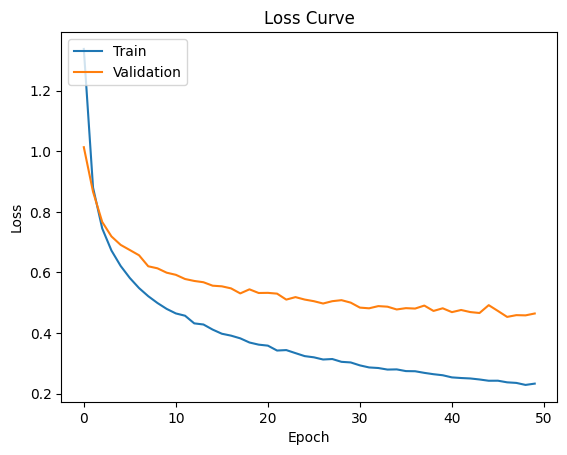

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_training_history(history)

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

28/28 [==============================] - 8s 283ms/step - loss: 0.4636 - accuracy: 0.8349
Validation Loss: 0.4635515511035919, Validation Accuracy: 0.8348729610443115


In [ ]:
# Display model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/CoLeaf/coleaf_model_denseNet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the model
model = load_model('/content/drive/MyDrive/CoLeaf/coleaf_model_denseNet.h5')

# Define the class labels based on your training setup
class_labels = ['boron-B_augmented', 'calcium-Ca_augmented',
                'iron-Fe_augmented', 'magnesium-Mg_augmented',
                'manganese-Mn_augmented', 'nitrogen-N_augmented',
                'phosphorus-P_augmented','potasium-K_augmented']

# Load an image for testing
img_path = '/content/drive/MyDrive/CoLeaf DATASET/boron-B/B (1).jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Make predictions
predictions = model.predict(img_array)

# Get the class with the highest probability
predicted_class = np.argmax(predictions)
predicted_class_name = class_labels[predicted_class]

print(f"The predicted class is: {predicted_class_name} (Class Number: {predicted_class+1})")


1/1 [==============================] - 3s 3s/step
The predicted class is: boron-B_augmented (Class Number: 1)
